# Project "Wikishop" (NLP BERT)

# Project description

Online store "Wikishop" launches a new service.
Now users can edit and supplement product descriptions, just like in wiki communities.
That is, clients propose their edits and comment on the changes of others.
The store needs a tool that will look for toxic comments and submit them for moderation.

At disposal there is a dataset with markup on the toxicity of edits.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import pandas as pd
import numpy as np
import re
import keras
import codecs
from sklearn.metrics import roc_auc_score, accuracy_score
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

C:\Users\A\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\A\anaconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\A\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Import data

In [2]:
df = pd.read_csv('datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


# Data Preprocessing

Our main data processing task is to clean up the text.

Let's create a function to clean up data using regular expressions.

In [5]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [6]:
df = standardize_text(df,'text')

<ipython-input-5-b283dd817410>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
<ipython-input-5-b283dd817410>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
<ipython-input-5-b283dd817410>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")


In [7]:
df.text.duplicated().sum()

112

Delete duplicates

In [8]:
df = df.drop_duplicates(subset = ['text']).reset_index(drop=True)

In [9]:
df

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m s...,0
2,hey man i m really not trying to edit war it...,0
3,more i can t make any real suggestions on im...,0
4,you sir are my hero any chance you remember...,0
...,...,...
159454,and for the second time of asking when ...,0
159455,you should be ashamed of yourself that is a ...,0
159456,spitzer umm theres no actual article for pr...,0
159457,and it looks like it was actually you who put ...,0


## Lemmatization

In [10]:
from nltk.stem import WordNetLemmatizer

In [11]:
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word)\
    for word in review.split()]) for review in corpus]

In [12]:
df['lemmatext'] = get_lemmatized_text(df['text'])

In [13]:
len(df[df['lemmatext'] != df['text']])

156223

## Tokenization

In [14]:
from nltk.tokenize import RegexpTokenizer

In [15]:
tokenizer_nltk =  RegexpTokenizer(r'\w+')

In [16]:
df['tokens'] = df['lemmatext'].apply(tokenizer_nltk.tokenize)

In [17]:
df

,text,toxic,lemmatext,tokens
0,explanation why the edits made under my userna...,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my..."
1,d aww he matches this background colour i m s...,0,d aww he match this background colour i m seem...,"[d, aww, he, match, this, background, colour, ..."
2,hey man i m really not trying to edit war it...,0,hey man i m really not trying to edit war it s...,"[hey, man, i, m, really, not, trying, to, edit..."
3,more i can t make any real suggestions on im...,0,more i can t make any real suggestion on impro...,"[more, i, can, t, make, any, real, suggestion,..."
4,you sir are my hero any chance you remember...,0,you sir are my hero any chance you remember wh...,"[you, sir, are, my, hero, any, chance, you, re..."
...,...,...,...,...
159454,and for the second time of asking when ...,0,and for the second time of asking when your vi...,"[and, for, the, second, time, of, asking, when..."
159455,you should be ashamed of yourself that is a ...,0,you should be ashamed of yourself that is a ho...,"[you, should, be, ashamed, of, yourself, that,..."
159456,spitzer umm theres no actual article for pr...,0,spitzer umm there no actual article for prosti...,"[spitzer, umm, there, no, actual, article, for..."
159457,and it looks like it was actually you who put ...,0,and it look like it wa actually you who put on...,"[and, it, look, like, it, wa, actually, you, w..."


# Data exploration

## Class balance

In [18]:
df.groupby('toxic').count()

,text,lemmatext,tokens
toxic,,,
0,143253,143253,143253
1,16206,16206,16206


Classes are unbalanced

## Measuring Sentence Length

In [19]:
all_words = [word for tokens in df['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set(all_words)))

In [20]:
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))

10964449 words total, with a vocabulary size of 163313
Max sentence length is 1403


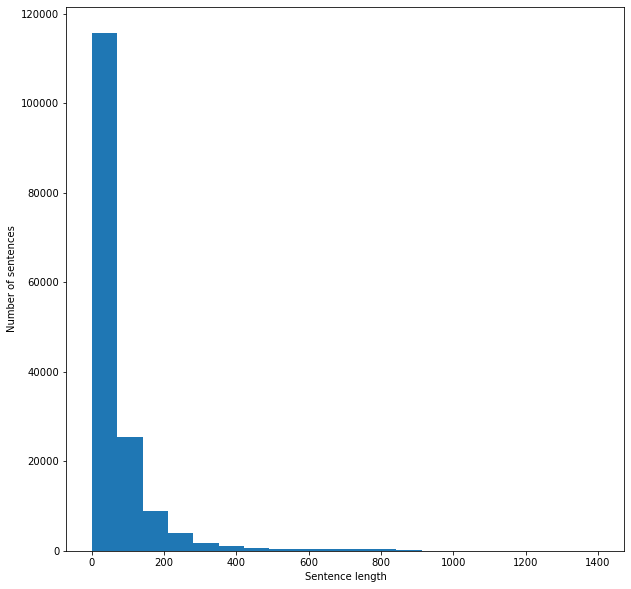

In [21]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths,bins=20)
plt.show()

* Most sentences are up to 100 words long
* A small number of sentences are in the range from 400 to 1400 words

# Model training

## Catboost

To begin with, let's go the simplest way and train catboost on raw data

In [22]:
X_train,X_test,y_train,y_test = train_test_split(df['lemmatext'],df['toxic'],test_size = 0.3,random_state = 42)

In [23]:
text_features = ['lemmatext']

In [24]:
train_pool = Pool(pd.DataFrame(X_train,columns = ['lemmatext']),y_train,text_features = text_features)

In [25]:
test_pool = Pool(pd.DataFrame(X_test,columns = ['lemmatext']),text_features = text_features)

In [26]:
model = CatBoostClassifier(random_state = 42,task_type = 'GPU',verbose = 250,max_depth = 6,learning_rate = 0.1)

In [27]:
model.fit(train_pool)

0:	learn: 0.5470112	total: 15.6ms	remaining: 15.6s
250:	learn: 0.1118594	total: 3.31s	remaining: 9.87s
500:	learn: 0.1016701	total: 6.53s	remaining: 6.5s
750:	learn: 0.0951310	total: 9.73s	remaining: 3.23s
999:	learn: 0.0898844	total: 12.9s	remaining: 0us


In [28]:
f1_score(y_test,model.predict(test_pool))

0.7902646926873037

## Bag of words

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [30]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

In [31]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Embeddings visualisation

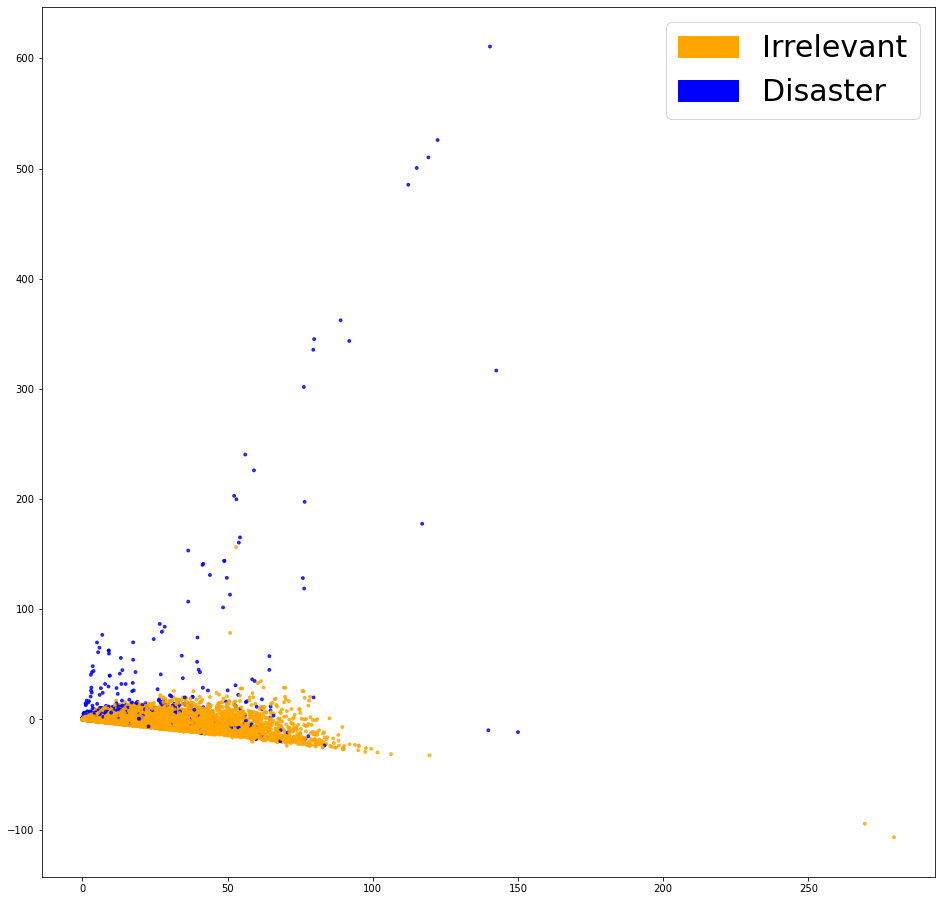

In [32]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
    lsa = TruncatedSVD(n_components = 2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue','blue']
    if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

fig = plt.figure(figsize = (16,16))
plot_LSA(X_train_counts,y_train)
plt.show()

Classes don't look well separated

### Model training

In [33]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42,n_jobs=-1,C=30.0)
clf.fit(X_train_counts, y_train)

LogisticRegression(C=30.0, n_jobs=-1, random_state=42)

In [34]:
f1_score(y_test,clf.predict(X_test_counts)) 

0.7758826724606193

Most important words for the classifier

In [35]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

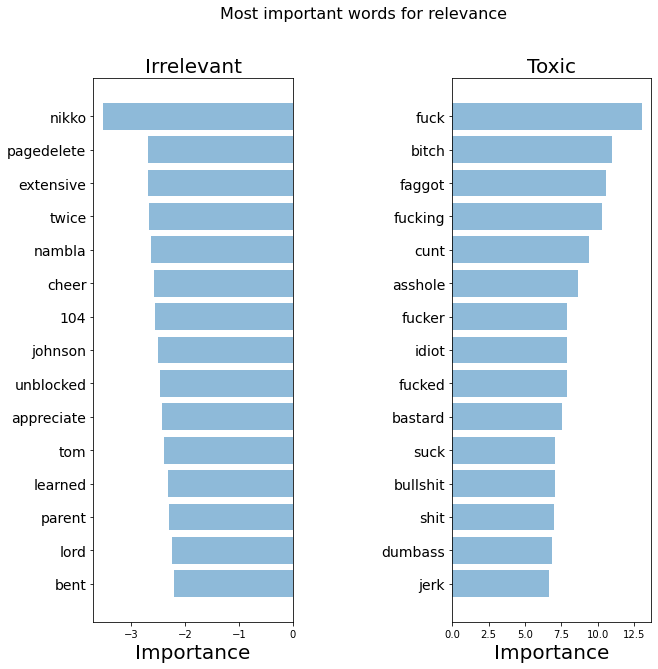

In [37]:
def plot_important_words(vectorizer, model, n, name):
    
    importance = get_most_important_features(vectorizer, model, n)
    
    top_scores = [a[0] for a in importance[0]['tops']]
    top_words = [a[1] for a in importance[0]['tops']]
    bottom_scores = [a[0] for a in importance[0]['bottom']]
    bottom_words = [a[1] for a in importance[0]['bottom']]
    
    y_pos = np.arange(len(top_words))
    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Toxic', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

plot_important_words(count_vectorizer, clf, 15, "Most important words for relevance")

Model correctly determines the words we need

## TF-IDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def tf_idf(df):
    tfidf = TfidfVectorizer()
    emb = tfidf.fit_transform(df)
    return emb, tfidf

X_train_tfidf,tfidf = tf_idf(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Embeddings visualisation

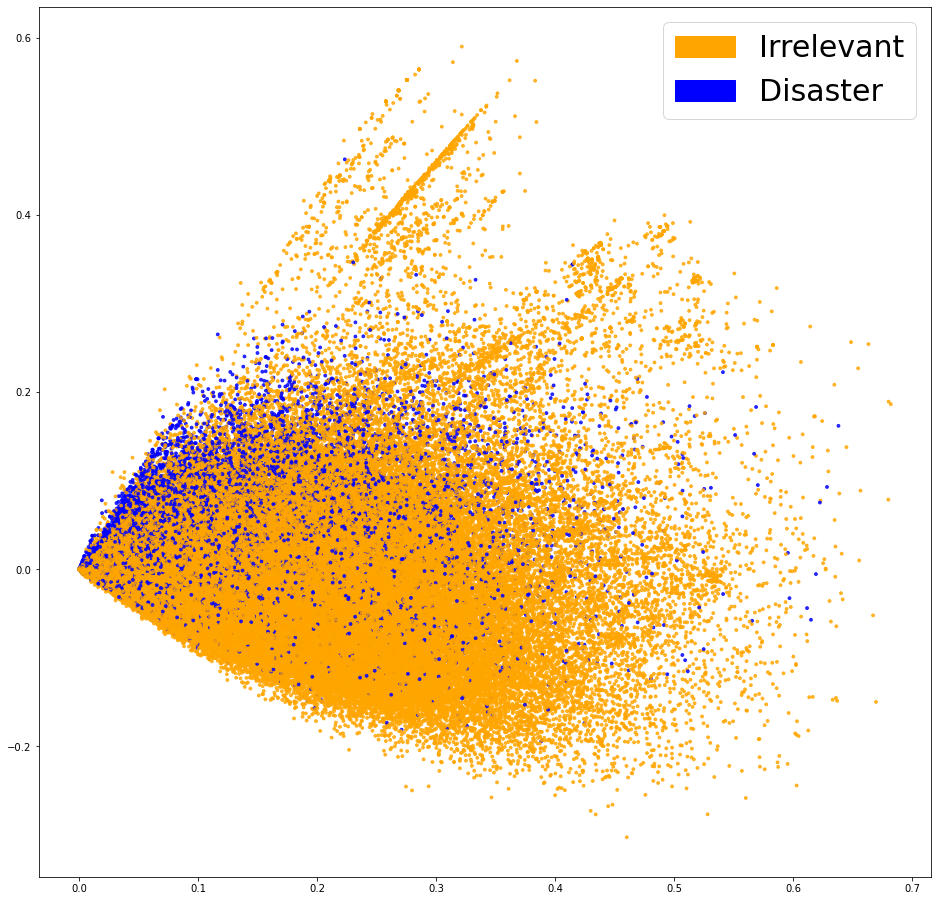

In [43]:
fig = plt.figure(figsize = (16,16))
plot_LSA(X_train_tfidf,y_train)
plt.show()

### Model training

In [44]:
clf_idf = LogisticRegression(random_state=42,n_jobs=-1,C=30.0)
clf_idf.fit(X_train_tfidf, y_train)

LogisticRegression(C=30.0, n_jobs=-1, random_state=42)

In [45]:
f1_score(y_test,clf_idf.predict(X_test_tfidf)) 

0.788235294117647

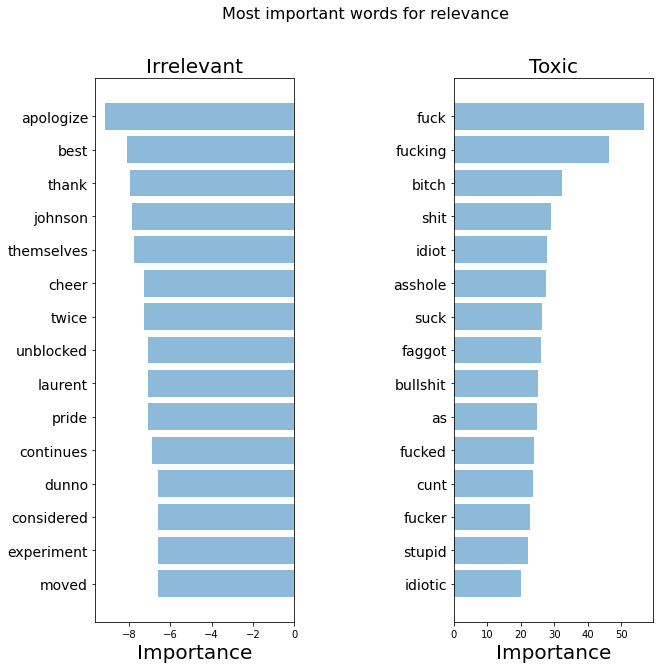

In [48]:
plot_important_words(tfidf, clf_idf, 15, "Most important words for relevance")

Model is even better

## word2vec

In [49]:
import gensim
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"

In [50]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

A quick way to get embeddings for our classifier is to average the word2vec score of all the words in our sentence.

In [51]:
def get_average_word2vec(tokens_list,vector,generate_missing = False,k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in token_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    lenght = len(vectorized)
    summed = np.sum(vectorized,axis=0)
    averaged = np.divide(summed,lenght)
    return averaged

In [52]:
def get_word2vec_embeddings(vectors,df,generate_missing = False):
    
    embeddings = df['tokens'].apply(lambda x: get_average_word2vec(x,
                                                                   vectors,
                                                                   generate_missing=generate_missing))
    return list(embeddings)

In [56]:
embeddings = get_word2vec_embeddings(word2vec,df)

X_train_word2vec,X_test_word2vec,y_train_word2vec,y_test_word2vec = train_test_split(embeddings, df['toxic'],
                                   test_size=0.3, random_state=40)

### Embeddings visualisation

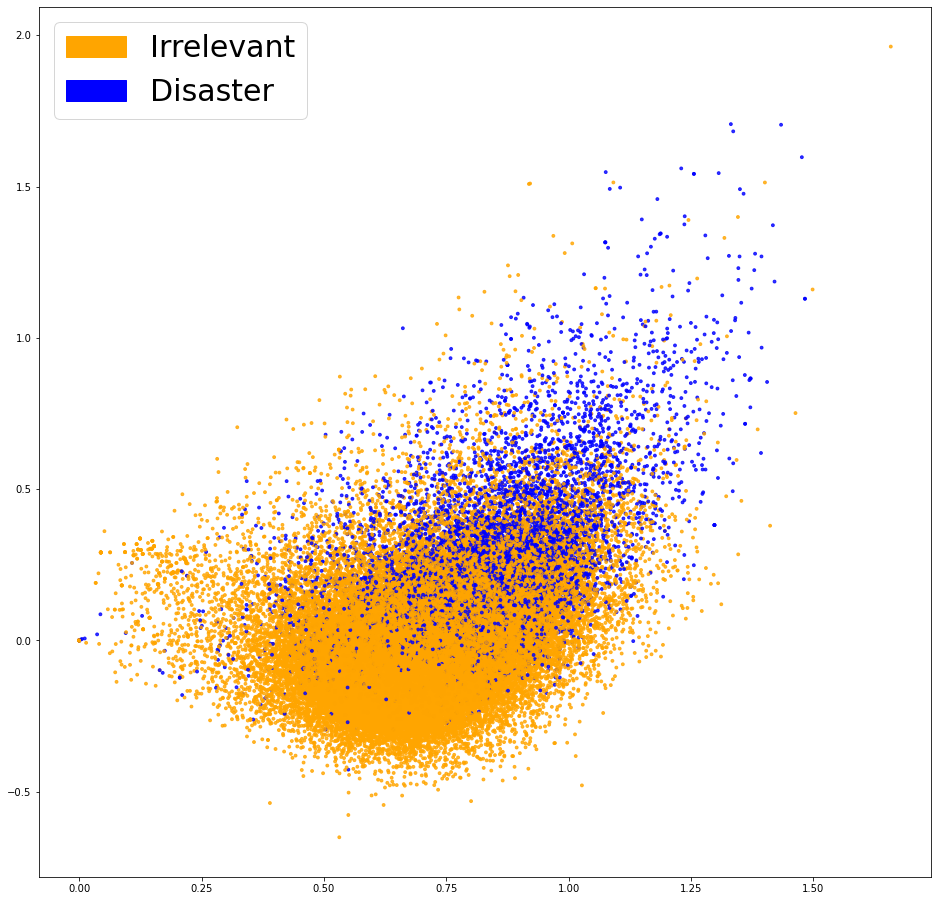

In [57]:
fig = plt.figure(figsize = (16,16))
plot_LSA(X_train_word2vec,y_train_word2vec)
plt.show()

Class separation is better

### Model training

In [64]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf_w2v.fit(X_train_word2vec,y_train_word2vec)

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

In [65]:
f1_score(y_test_word2vec,clf_w2v.predict(X_test_word2vec))

0.6352781136638451

Oddly enough, but the model showed worse quality than the rest

# Conclusion

* The best model turned out to be catboost out of the box
* Word2vec separates classes better than others, but as a prediction it doesn't win